# BASH header（shebang）告诉编译器是bash语言
SBATCH环境设置是清华推荐的，这里申请c=8，因为并行两个pool，每个4线程，这个程序只能处理一对样本（WT pool 和 mutant pool），如果需要多对，请改为 array模式，并且注意样本对应关系

In [ ]:
#!/bin/bash
#SBATCH -J PoolSeq
#SBATCH -p Acluster
#SBATCH -n 1
#SBATCH -c 8
#SBATCH --output=%j.out
#SBATCH --error=%j.err

#set environment
source /Share/samples/Acluster.sh
source /Share/home/dengzg1993/bin/DZG_env.sh

# 全局变量, Vx.cohort.snp.final.vcf.gz需要引用

In [ ]:
CurrentDIR=$(pwd)
TempDIR=/Share/home/dengzg1993/tmp
REF_FASTA=/Data/ChenhaodongLab/Data_deposited/Reference_genome/Physcomitrella/Gd_v6.1/Ppatens_870_V6.fasta
SNP_SITES=/Share/home/dengzg1993/Analyses/DNASeq/Physcomitrella/1.WGS/05.Villersexel/2024.11.25_v6.1/4.annotate/Results/Vx.cohort.snp.final.vcf.gz

# 读取样本，不是批量模式，只能读入一对样本 mut_pool和 WT_pool 

In [ ]:
dos2unix $CurrentDIR/sample_pool.tsv

read SAMPLE_MUT READ1_MUT READ2_MUT PLOIDY_MUT < <(awk 'NR==2 {print $1, $2, $3, $4}' $CurrentDIR/sample_pool.tsv)
read SAMPLE_WT READ1_WT READ2_WT PLOIDY_WT < <(awk 'NR==3 {print $1, $2, $3, $4}' $CurrentDIR/sample_pool.tsv)

# -----------------------------
estimate_depth() {
    local sample_name=$1
    local read1=$2
    local __resultvar=$3

    NUM_READS_R1=$(zcat "$read1" | wc -l)
    NUM_READS_R1=$((NUM_READS_R1/4))

    GENOME_SIZE=$(grep -v ">" "$REF_FASTA" | wc -c)
    DEPTH=$(echo "$NUM_READS_R1 * 150 * 2 / $GENOME_SIZE" | bc)
	
    echo "Estimated depth is '$DEPTH' ($sample_name)"
	
    eval $__resultvar="'$DEPTH'"
}

estimate_depth "$SAMPLE_MUT" "$READ1_MUT" DEPTH_MUT
estimate_depth "$SAMPLE_WT" "$READ1_WT" DEPTH_WT

mkdir -p $CurrentDIR/report $CurrentDIR/1.mapping $CurrentDIR/2.variants $CurrentDIR/3.output $CurrentDIR/4.result
log_step() {
    echo "[$(date '+%Y-%m-%d %H:%M:%S')] $1"
}
log_step "Start"


## 例子：
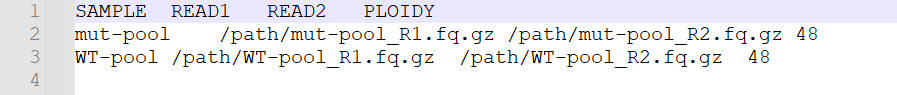

# FastQC

In [ ]:
log_step "FastQC"
fastqc -o $CurrentDIR/report --noextract $READ1_MUT $READ2_MUT &> $CurrentDIR/report/fastqc_m.log &
fastqc -o $CurrentDIR/report --noextract $READ1_WT $READ2_WT &> $CurrentDIR/report/fastqc_w.log &
wait

# 映射和去重，要求准确性不是那么高，不做 trim reads之类的操作

In [ ]:
log_step "Reads mapping and dedup"
process_sample() {
    local sample_name=$1
    local read1=$2
    local read2=$3

    bwa mem -t 4 -M \
        -R "@RG\tID:$sample_name\tLB:$sample_name\tPL:ILLUMINA\tPM:HISEQ\tSM:$sample_name" \
        $REF_FASTA $read1 $read2 \
        | samtools view -Sb - \
        | samtools sort -o $CurrentDIR/1.mapping/$sample_name.sorted.bam

    picard MarkDuplicates \
        -I $CurrentDIR/1.mapping/$sample_name.sorted.bam \
        -M $CurrentDIR/1.mapping/sorted_dedup_metrics-${sample_name}.txt \
        --TMP_DIR $TempDIR \
        -O $CurrentDIR/1.mapping/$sample_name.sorted_dedup_reads.bam

    samtools index $CurrentDIR/1.mapping/$sample_name.sorted_dedup_reads.bam
}

process_sample $SAMPLE_MUT $READ1_MUT $READ2_MUT &
process_sample $SAMPLE_WT $READ1_WT $READ2_WT &
wait

# 变异检测

In [ ]:
log_step "Variant Calling"
variant_calling() {
    local sample_name=$1
    local ploidy=$2

    gatk HaplotypeCaller -R $REF_FASTA \
        -I $CurrentDIR/1.mapping/$sample_name.sorted_dedup_reads.bam \
        --intervals $SNP_SITES --sample-ploidy $ploidy -ERC GVCF \
        -O $CurrentDIR/2.variants/$sample_name.g.vcf.gz
}

variant_calling $SAMPLE_MUT $PLOIDY_MUT &
variant_calling $SAMPLE_WT $PLOIDY_WT &
wait

# 合并变异文件

In [ ]:
log_step "Merge VCF"
gatk CombineGVCFs -R $REF_FASTA \
    --variant $CurrentDIR/2.variants/$SAMPLE_MUT.g.vcf.gz \
    --variant $CurrentDIR/2.variants/$SAMPLE_WT.g.vcf.gz \
    -O $CurrentDIR/2.variants/Combine.g.vcf.gz

gatk IndexFeatureFile -I $CurrentDIR/2.variants/Combine.g.vcf.gz

分染色体，有时候有些染色体会报错，删除之

In [ ]:
grep '>' $REF_FASTA | sed 's/>//' | cut -d ' ' -f 1 > $CurrentDIR/2.variants/chr.list.txt

while read CHR; do
    echo "Processing $CHR ..."
    gatk --java-options "-Xmx4G" GenotypeGVCFs \
        -R $REF_FASTA \
        -V $CurrentDIR/2.variants/Combine.g.vcf.gz \
        -L $CHR \
        -O $CurrentDIR/3.output/Combine.$CHR.vcf.gz
done < $CurrentDIR/2.variants/chr.list.txt

gatk MergeVcfs \
    $(for f in $CurrentDIR/3.output/Combine.*.vcf.gz; do echo -n "-I $f "; done) \
    -O $CurrentDIR/4.result/Combine.vcf.gz

gatk IndexFeatureFile -I $CurrentDIR/4.result/Combine.vcf.gz

# 提取等位基因频率

In [ ]:
log_step "Extract Allele frequency"
gatk VariantFiltration -R $REF_FASTA \
    -V $CurrentDIR/4.result/Combine.vcf.gz \
    -O $CurrentDIR/4.result/Combine.filter.vcf.gz \
    -filter-name "hard_filter" \
    -filter "QD < 2.0 || SOR > 3.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0"

gatk SelectVariants --exclude-filtered --select-type-to-include SNP \
    --restrict-alleles-to BIALLELIC \
    -select "vc.getGenotype('$SAMPLE_MUT').getDP() > 0.3 * $DEPTH_MUT" \
    -select "vc.getGenotype('$SAMPLE_MUT').getDP() < 3 * $DEPTH_MUT" \
    -select "vc.getGenotype('$SAMPLE_WT').getDP() > 0.3 * $DEPTH_WT" \
    -select "vc.getGenotype('$SAMPLE_WT').getDP() < 3 * $DEPTH_WT" \
    -V $CurrentDIR/4.result/Combine.filter.vcf.gz \
    -O $CurrentDIR/4.result/Combine.snp.cleaned.vcf.gz

gatk VariantsToTable -V $CurrentDIR/4.result/Combine.snp.cleaned.vcf.gz \
    -F CHROM -F POS -GF AD \
    -O $CurrentDIR/4.result/Combine.results_var_AD.table


Combine.results_var_AD.table下载为最终结果文件

清理空间，建议结果没问题手动删除1，2，3 文件夹